In [1]:
import os
from dotenv import load_dotenv
import nibabel as nib
from nibabel.orientations import aff2axcodes
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm

from utils.registration import nifit_info, correct4registration, slice2chunk_align
from utils.preproc import FUSCleaner

from utils.glm import run_glm_analysis
from nilearn.glm.contrasts import compute_contrast
from scipy.ndimage import affine_transform
import SimpleITK as sitk

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from joblib import Parallel, delayed

In [2]:
load_dotenv()
base_dir = os.getenv('BASE_DIR')
task_dir = os.path.join(base_dir, 'task_data')
register_dir = os.path.join(base_dir, 'slice2chunk_grouper', '061824_1-5')
register_dir2 = os.path.join(base_dir, 'slice2chunk_grouper', '060324_8-5')
figure_dir = os.path.join(base_dir, 'figures')

os.makedirs(figure_dir, exist_ok=True)

In [3]:
def transform_affine(affine_matrix):
    # Make a copy to avoid modifying the original matrix
    transformed_matrix = affine_matrix.copy()
    
    # Flip the signs of the first and third diagonal elements
    transformed_matrix[0, 0] = -affine_matrix[0, 0]
    transformed_matrix[2, 2] = -affine_matrix[2, 2]
    
    # Set the translation components (last column) to 0
    transformed_matrix[0, 3] = 0
    transformed_matrix[2, 3] = 0
    
    return transformed_matrix

In [5]:
raw_file = os.path.join(task_dir, 'Grouper_audiocue_060324_2D.nii')
raw_file2 = os.path.join(task_dir, 'Grouper_audiocue_060324_2D.nii.gz')

raw_image = nib.load(raw_file)
raw_image2 = nib.load(raw_file2)

aff2axcodes(raw_image.affine), aff2axcodes(raw_image2.affine)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(('L', 'A', 'S'), ('R', 'A', 'I'))

In [6]:
def load_nifti_image(file_path: str):
    """Loads a NIfTI image and returns its data array and affine matrix."""
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    return data, affine, img.header


def process_and_save_image(first_img_path: str, second_img_path: str, output_path: str):
    """Loads the images, applies affine corrections, flips the data, and saves the corrected image."""
    # Load the first image (4D) and the second image (corrected slice)
    first_data, _, _ = load_nifti_image(first_img_path)
    _, second_affine, second_header = load_nifti_image(second_img_path)

    corrected_affine = second_affine.copy()
    corrected_affine[[0, 1]] = corrected_affine[[1, 0]]

    print("Corrected Affine:\n", corrected_affine)
    print(aff2axcodes(corrected_affine))
    
    # reflect z to be positive
    transform_matrix = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, -1, 0],
                                [0, 0, 0, 1]])

    transformed_affine = corrected_affine @ transform_matrix

    print(transformed_affine)

    flipped_data = np.flip(first_data, axis=2)

    new_img = nib.Nifti1Image(flipped_data, transformed_affine, second_header)

    nib.save(new_img, output_path)
    print(f"Corrected image saved to {output_path}")

In [7]:
# correct 2D x timepoints for later analysis
output_path = os.path.join(register_dir2, 'Grouper_audiocue_060324_2D_timepoints_corrected.nii.gz')
process_and_save_image(raw_file, raw_file2, output_path)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Corrected Affine:
 [[ 0.          0.40000001  0.         -0.        ]
 [ 0.11        0.          0.         -0.        ]
 [ 0.          0.         -0.09856     0.        ]
 [ 0.          0.          0.          1.        ]]
('A', 'R', 'I')
[[0.         0.40000001 0.         0.        ]
 [0.11       0.         0.         0.        ]
 [0.         0.         0.09856    0.        ]
 [0.         0.         0.         1.        ]]
Corrected image saved to /Users/yibeichen/Desktop/fusi/slice2chunk_grouper/060324_8-5/Grouper_audiocue_060324_2D_timepoints_corrected.nii.gz


In [8]:
file = os.path.join(register_dir2, 'Grouper_audiocue_060324_corrected-transformed.nii.gz')
img = nib.load(file).get_fdata()
img.shape

(147, 200, 135)

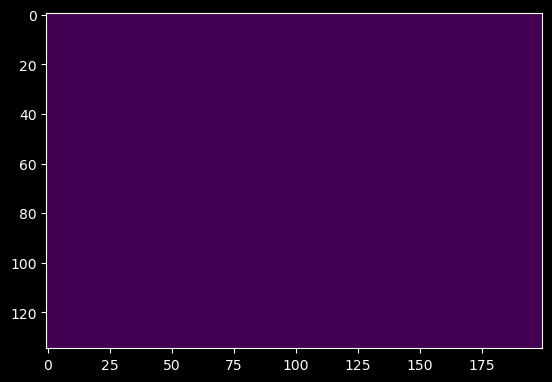

In [13]:
plt.imshow(np.rot90(img[89,:,:]))
plt.show()